# Learning outcomes
- image hostogram
- Histogram equalization / CLAHE:
    * purpose contrast enhancement (same effect as simple scalar multiplication)
- Thresholding (end result: binary mask with 255 as foreground)
- Morphological operation (manipulate the mask)
    - Erosion
    - Dilation
    - Opening
    - Closing
- color spaces: RGB, HSV and L\*a*b
- Color based segmentation (HSV), Hue represents color, one channel encode color information.

# Setup

In [1]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

## Image histogram

In [2]:
img = cv.imread("images/lena.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [3]:
# 2 way to compute histogram
%timeit hist = cv.calcHist([gray], [0], None, [255], [0,256])
%timeit hist, _ = np.histogram(gray.flatten(), 256)

57.5 µs ± 824 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
2.47 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


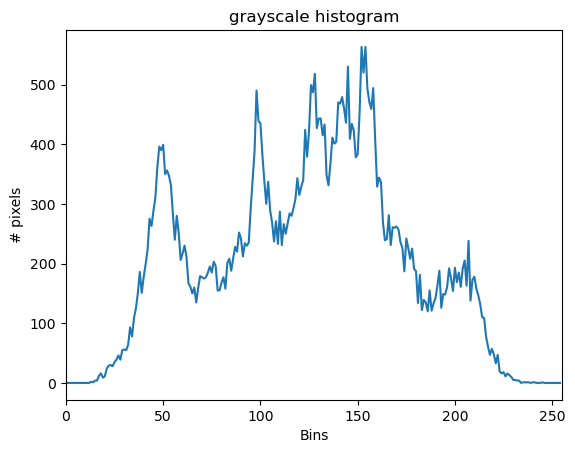

In [4]:
# construct histogram
hist = cv.calcHist([gray], [0], None, [255], [0,256])

plt.figure()
plt.title("grayscale histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.plot(hist)
plt.xlim([0, 255])
plt.show()

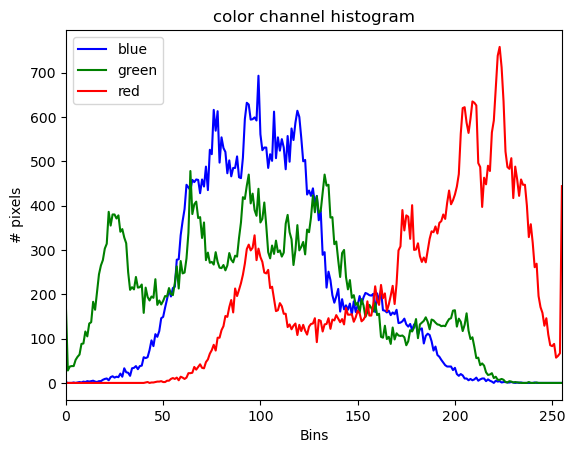

In [5]:
# compute histogram for all the channel
channels = cv.split(img)
colors = ("blue", "green", "red")

plt.figure()
plt.title("color channel histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")

for ch, color in zip(channels, colors):
    hist = cv.calcHist([ch], [0], None, [256], [0, 256])
    plt.plot(hist, color=color, label=color)
    
plt.xlim([0, 255])
plt.legend()
plt.show()

## Histogram equalization
- no parameter required
- weakness: under-enhance, over-enhance (overcome, CLAHE)

In [6]:
img = cv.imread("images/low_contrast_img.jfif")
show_img("low_contrast", img)

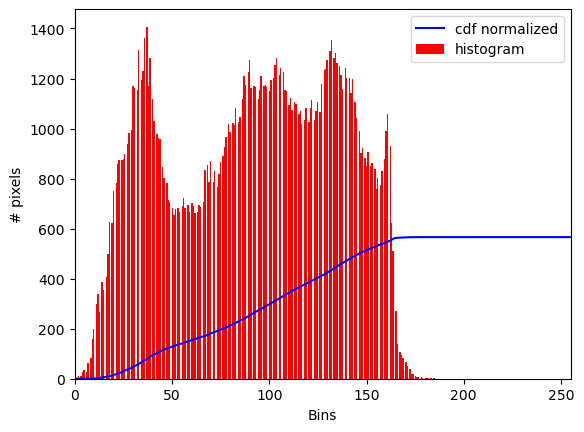

In [7]:
# histogram
hist = cv.calcHist([img], [0], None, [256], [0,256])

# compute cdf
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.figure()
plt.plot(cdf_normalized, color='b')
plt.hist(img.flatten(), 256, color='r')
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.xlim([0, 255])
plt.legend(("cdf normalized", "histogram"))
plt.show()

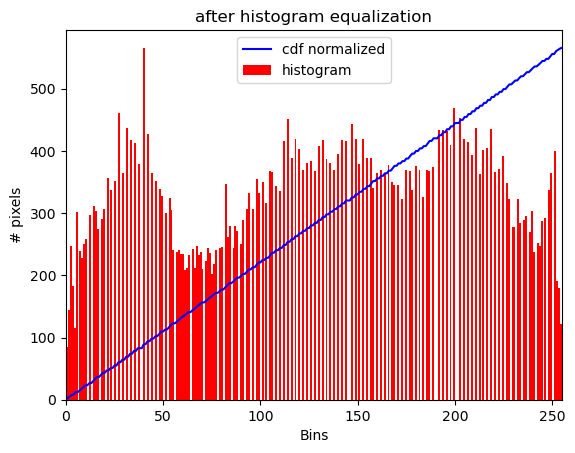

In [8]:
# histogram equalization
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
eq = cv.equalizeHist(img)

# histogram
hist = cv.calcHist([eq], [0], None, [256], [0,256])

# compute cdf
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.figure()
plt.plot(cdf_normalized, color='b')
plt.hist(eq.flatten(), 256, color='r')
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.xlim([0, 255])
plt.legend(("cdf normalized", "histogram"))
plt.title("after histogram equalization")
plt.show()

In [9]:
cv.imshow("original", img)
show_img("equalization", eq)

In [10]:
#
img = cv.imread("images/dog1.jfif", 0)

#equalization
eq = cv.equalizeHist(img)

#CLAHE
clahe = cv.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
dst = clahe.apply(img)

cv.imshow("original", img)
cv.imshow("equalization", eq)
show_img("clahe", dst)

In [11]:
#
img = cv.imread("images/winter_low_contrast.jfif", 0)

#equalization
eq = cv.equalizeHist(img)

#CLAHE
clahe = cv.createCLAHE(clipLimit=4, tileGridSize=(9, 9))
dst = clahe.apply(img)

cv.imshow("original", img)
cv.imshow("equalization", eq)
show_img("clahe", dst)

### Exercise 1
Try histogram equalization and CLAHE on 'winter.jfif' and display the results together with the original grayscale image. Comment on the results obtained.

In [12]:
#
img = cv.imread("images/winter.jfif", 0)

#equalization
eq = cv.equalizeHist(img)

#CLAHE
clahe = cv.createCLAHE(clipLimit=5, tileGridSize=(8, 8))
dst = clahe.apply(img)

cv.imshow("original", img)
cv.imshow("equalization", eq)
show_img("clahe", dst)

## Thresholding

Otsu thresholding do well in bimodel histogram
- no need to define T in Otsu thresholsing

In [13]:
[i for i in dir(cv) if i.startswith("THRESH")]

['THRESH_BINARY',
 'THRESH_BINARY_INV',
 'THRESH_MASK',
 'THRESH_OTSU',
 'THRESH_TOZERO',
 'THRESH_TOZERO_INV',
 'THRESH_TRIANGLE',
 'THRESH_TRUNC']

In [14]:
img = np.fromfunction(lambda i, j: j, (50, 256), dtype=np.uint8)

def trackbar(x):
    _, img1 = cv.threshold(img, x, 255, cv.THRESH_BINARY)
    _, img2 = cv.threshold(img, x, 255, cv.THRESH_BINARY_INV)
    _, img3 = cv.threshold(img, x, 255, cv.THRESH_TRUNC)
    _, img4 = cv.threshold(img, x, 255, cv.THRESH_TOZERO)
    _, img5 = cv.threshold(img, x, 255, cv.THRESH_TOZERO_INV)
    
    cv.imshow("window", np.vstack((img1, img2 ,img3, img4, img5)))
    
cv.namedWindow("window")
cv.createTrackbar("threshold", "window", 100, 255, trackbar)
cv.waitKey(0)

27

## Comparison on the thresholding methods

In [15]:
img = cv.imread("images/noisy.jfif", 0)
show_img("noisy image", img)

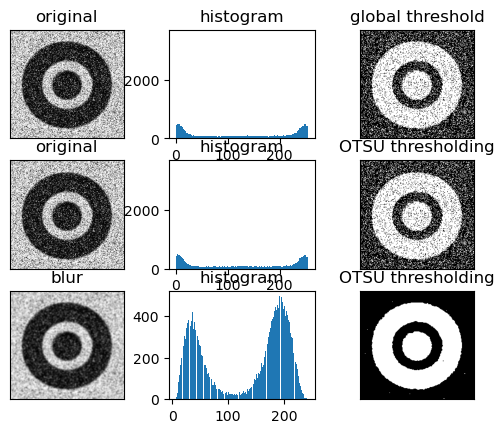

In [16]:
# apply 3 method
#1: global threshold
th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)[1] # make circle and donut being white, use inv

#2: OTSU threshold
th2 = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

#3 : Gaussian blur + OTSU threshold
blur = cv.GaussianBlur(img, (5, 5), 0)
th3 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

imgs = [img, 0, th1,
       img, 0, th2,
       blur, 0, th3]

titles = ("original", "histogram", "global threshold",
         "original", "histogram", "OTSU thresholding",
         "blur", "histogram", "OTSU thresholding")

for i in range(3):
    plt.subplot(3, 3, 3*i+1), plt_img(imgs[3*i], title=titles[3*i])
    plt.subplot(3, 3, 3*i+2), plt.hist(imgs[3*i].flatten(), 256)
    plt.title(titles[3*i+1])
    plt.subplot(3, 3, 3*i+3), plt_img(imgs[3*i+2], title=titles[3*i+2])

plt.show()

## Morphological operations
- erosion
- dilation
- opening (erosion + dilation)
- closing (dilation + erosion)

In [17]:
# define structuring element
kernel = np.ones((3, 3), dtype=np.uint8)

# erosion
dst = cv.erode(th3, kernel, iterations=1)

# show
img_combined = np.hstack((th3, dst))

show_img("erosion", img_combined)

In [18]:
# define structuring element
kernel = np.ones((3, 3), dtype=np.uint8)

# erosion
dst = cv.dilate(th3, kernel, iterations=1)

# show
img_combined = np.hstack((th3, dst))

show_img("dilate", img_combined)

In [20]:
# tracbar function and while loop
def nothing(x):
    pass

wn = "window"
cv.namedWindow(wn)
cv.createTrackbar("size", wn, 3, 10, nothing)
cv.createTrackbar("iter", wn, 3, 10, nothing)

while (1):
    size = cv.getTrackbarPos("size", wn)
    if size < 3:
        size = 3
        
    iteration = cv.getTrackbarPos("iter", wn)
    if iteration < 1:
        iteration = 1
        
    # define the kernel
    kernel = np.ones((size, size), dtype=np.uint8)
    # erosion
    erosion = cv.erode(th3, kernel, iterations=iteration)
    
    cv.imshow(wn, erosion)
    k = cv.waitKey(1) & 0xFF
    if k==27:
        break

cv.destroyAllWindows()

In [21]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (8, 8))

In [22]:
# closing
res = cv.morphologyEx(th3, cv.MORPH_CLOSE, kernel, iterations=2)

# show
img_combined = np.hstack((th3, res))

show_img("closing", img_combined)

## Color spaces
- RGB (the most prevalent color space. Any picture is stored under this format. But the downside of this color space is that there is no clear way to seperate chroma (color and its saturation)). Not suitable for color based segmentation
- HSV (Hue, Saturation, Value)
    - HUE -> color (make use of hue to segment color)
    - saturation -> purity of the color
    - value -> brightness / luminance
- LAB
    - perceptual uniformity (the Euclidean distance in the color space correspond to erceptual uniformity)

In [23]:
# Image sharpening with LAB
#1: split image to L, a ,b
#2: Sharpen the L channel
#3: merge color chanels

img = cv.imread("images/lena.jfif")

img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)
l, a, b = cv.split(img_lab)

# define sharpening kernel
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
l_sharpened = cv.filter2D(l, -1, kernel)

# merge
img_lab_merge = cv.merge((l_sharpened, a, b))
dst = cv.cvtColor(img_lab_merge, cv.COLOR_Lab2BGR)

cv.imshow("original", img)
show_img("sharpen", dst)

## demo on color based segmentation

In [24]:
img = cv.imread("images/color_space/pant.jfif")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

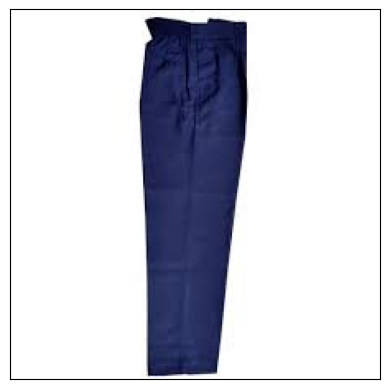

In [25]:
plt_img(img)
plt.show()

## Show the pixels in rgb color space

In [26]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

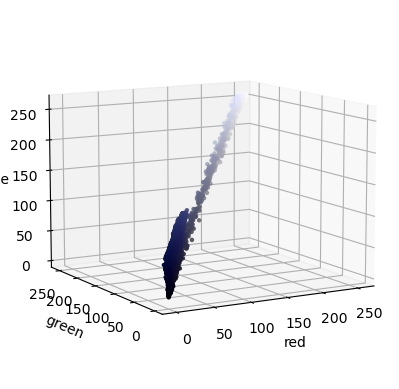

In [27]:
# split the color channels
r, g, b = cv.split(img)
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1, projection='3d')

# encode the color information
pixel_colors = img.reshape((-1, 3))
norm = colors.Normalize()
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axes.scatter(r.ravel(), g.ravel(), b.ravel(), facecolors=pixel_colors, marker=".")
axes.view_init(elev=10, azim=240)
axes.set_xlabel("red")
axes.set_ylabel("green")
axes.set_zlabel("blue")
plt.show()

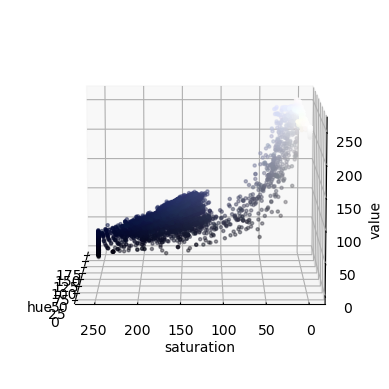

In [28]:
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

h, s, v = cv.split(img_hsv)
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1, projection='3d')


axes.scatter(h.ravel(), s.ravel(), v.ravel(), facecolors=pixel_colors, marker=".")
axes.view_init(elev=10, azim=180)
axes.set_xlabel("hue")
axes.set_ylabel("saturation")
axes.set_zlabel("value")
plt.show()

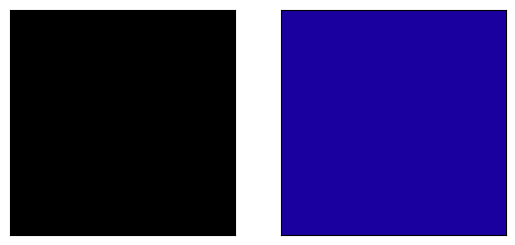

In [29]:
blue_low = (85, 90, 0)
blue_high = (125, 255, 160)

square1 = np.full((10, 10, 3), blue_low, dtype=np.uint8)
square2 = np.full((10, 10, 3), blue_high, dtype=np.uint8)

plt.subplot(121), plt_img(cv.cvtColor(square1, cv.COLOR_HSV2RGB))
plt.subplot(122), plt_img(cv.cvtColor(square2, cv.COLOR_HSV2RGB))
plt.show()

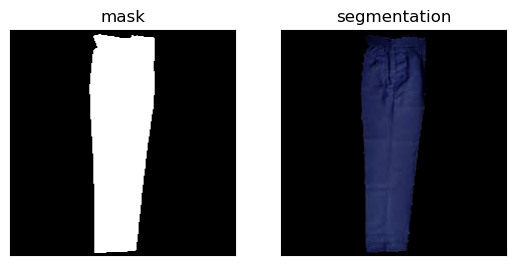

In [30]:
# color base segmentation
mask = cv.inRange(img_hsv, blue_low, blue_high)
res = cv.bitwise_and(img, img, mask=mask)

plt.subplot(121), plt_img(mask, title="mask")
plt.subplot(122), plt_img(res, title="segmentation")
plt.show()

### Exercise
- Does the segmentation generalize to other blue pant images?
    * Import all blue pant images ("pant1.jfif" - "pant5.jfif")
    * Perform color segmentation
    * Display the results

In [31]:
def color_seg(img, low_color, high_color, smooth=True):
    """Arguements
    img: source image (RGB)
    low_color: hsv_low
    high_color: hsv_high
    smooth: boolean (Gaussian blurring)"""
    img_ori = img.copy()
    if smooth:
        img = cv.GaussianBlur(img, (5, 5), 0)
        
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    mask = cv.inRange(img_hsv, low_color, high_color)
    
    # morphological operations
    mask = cv.erode(mask, None, iterations=2)
    mask = cv.dilate(mask, None, iterations=2)
    
    return cv.bitwise_and(img_ori, img_ori, mask=mask)

imgs = []
for i in range(1, 6):
    img = cv.imread(cv.samples.findFile(f"images/color_space/pant{i}.jfif"))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)

res = [color_seg(img, blue_low, blue_high) for img in imgs]

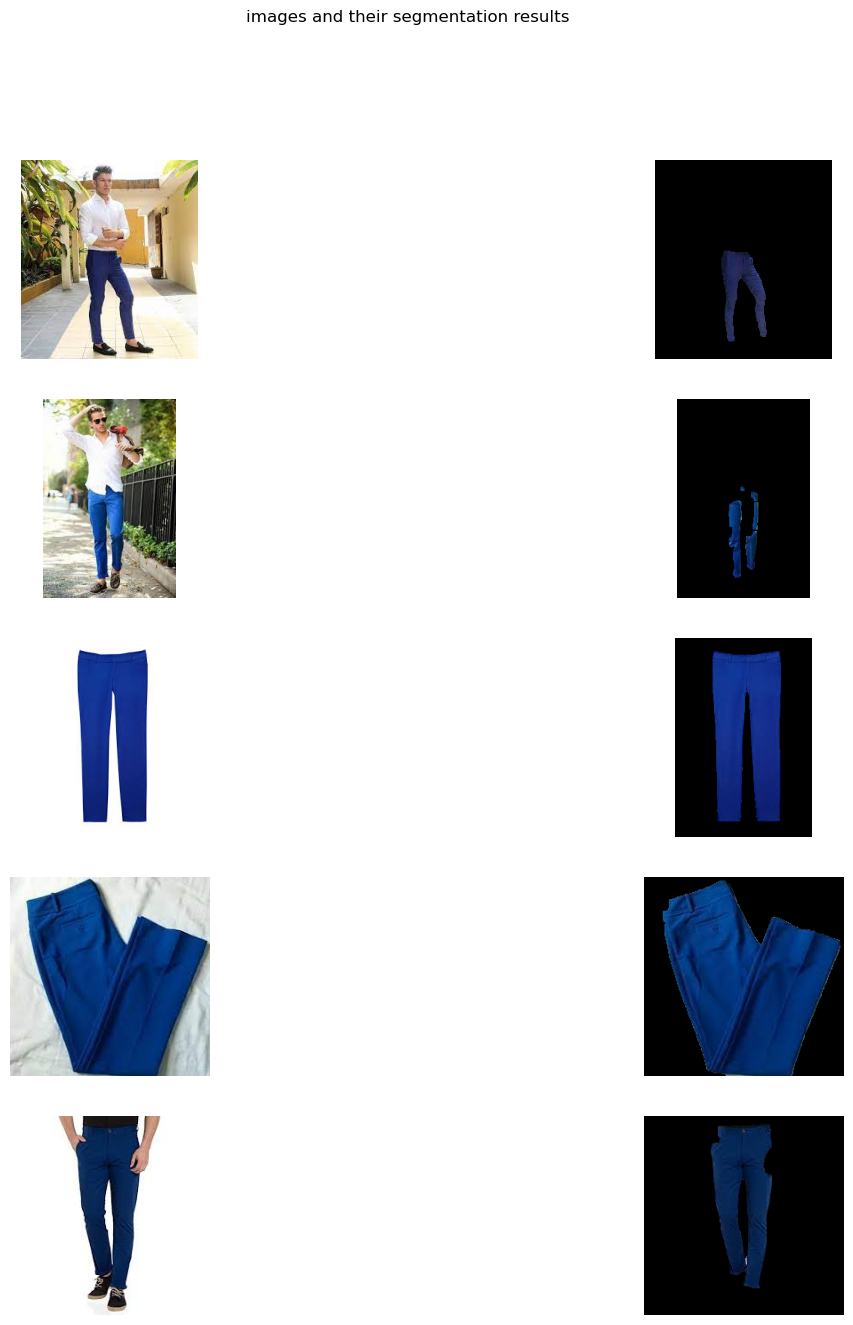

In [32]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))

for i in range(5):
    ax[i][0].imshow(imgs[i])
    ax[i][0].axis("off")
    ax[i][1].imshow(res[i])
    ax[i][1].axis("off")

fig.suptitle("images and their segmentation results")
plt.show()

## Weekly activity

1. Write a program to segment the boat and the people on it from the background. Follow the instruction below:
 - Use 'boat.jpg' as input.
 - Apply Otsu thresholding.
 - Draw bounding box to identify the region where the boat and people are located.

In [33]:
img = cv.imread("images/boat.jpg")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Binary Threshold
th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

# find contour
contours, _ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

#draw contour
img_copy = img.copy()
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    cv.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

show_img("contours", img_copy)

2. Write a program to visualize the effect of size of structuring element on the morphological transformation (e.g. erosion, dilation, opening, and closing).

- Load the 'leaf.jfif' and perform thresholding to segment the leaf from the background.
- Create a GUI containing trackbar to control the size of structuring element and display the resulting image on a window alongside the trackbar.

In [34]:
# Load the input image
image = cv.imread("images/leaf.jfif", 0)

# Create a window for the GUI
cv.namedWindow('Morphological Transformations')

# Callback function for the trackbar
def update(val):
    size = cv.getTrackbarPos('Size', 'Morphological Transformations')
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (size, size))
    
    # Perform morphological transformations
    erosion = cv.erode(segmented_leaf, kernel, iterations=1)
    dilation = cv.dilate(segmented_leaf, kernel, iterations=1)
    opening = cv.morphologyEx(segmented_leaf, cv.MORPH_OPEN, kernel)
    closing = cv.morphologyEx(segmented_leaf, cv.MORPH_CLOSE, kernel)
    
    # Stack the images horizontally for visualization
    result = np.hstack((erosion, dilation, opening, closing))
    
    cv.imshow('Morphological Transformations', result)

# Perform thresholding to segment the leaf from the background
_, thresholded = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Find the largest connected component (assumed to be the leaf)
contours, _ = cv.findContours(thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv.contourArea)
segmented_leaf = np.zeros_like(image)
cv.drawContours(segmented_leaf, [largest_contour], -1, 255, thickness=cv.FILLED)

# Create and set up the trackbar
cv.createTrackbar('Size', 'Morphological Transformations', 1, 30, update)

# Initialize the GUI with the initial trackbar value
update(1)

# Wait for the user to press a key and then close the window
cv.waitKey(0)
cv.destroyAllWindows()

3. Apply the steps shown in exercise 4 to segment the porcelain from these images: "porcelain1.jfif" - "porcelain5.jfif".

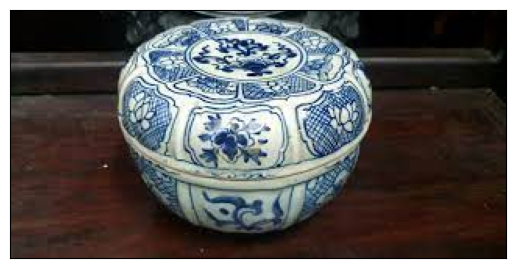

In [35]:
img = cv.imread("images/color_space/porcelain1.jfif")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt_img(img)
plt.show()

In [36]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

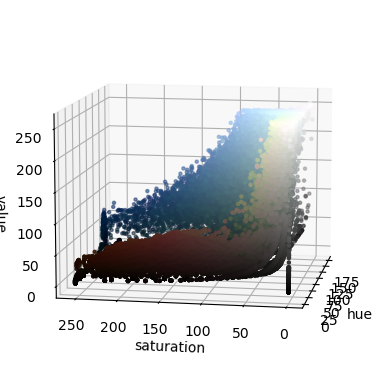

In [37]:
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

h, s, v = cv.split(img_hsv)
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1, projection='3d')

# encode the color information
pixel_colors = img.reshape((-1, 3))
norm = colors.Normalize()
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axes.scatter(h.ravel(), s.ravel(), v.ravel(), facecolors=pixel_colors, marker=".")
axes.view_init(elev=10, azim=190)
axes.set_xlabel("hue")
axes.set_ylabel("saturation")
axes.set_zlabel("value")
plt.show()

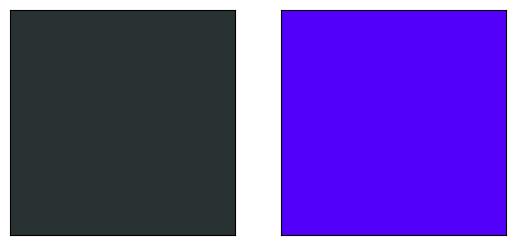

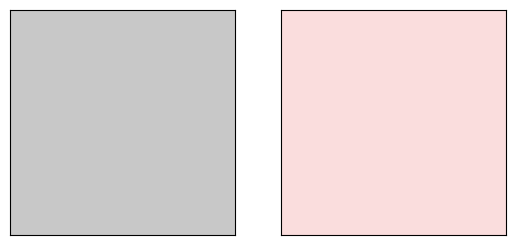

In [38]:
blue_low = (90, 50, 50)
blue_high = (130, 255, 250)

white_low = (0, 0, 200)
white_high = (180, 30, 250)

square1 = np.full((10, 10, 3), blue_low, dtype=np.uint8)
square2 = np.full((10, 10, 3), blue_high, dtype=np.uint8)

square3 = np.full((10, 10, 3), white_low, dtype=np.uint8)
square4 = np.full((10, 10, 3), white_high, dtype=np.uint8)

plt.subplot(121), plt_img(cv.cvtColor(square1, cv.COLOR_HSV2RGB))
plt.subplot(122), plt_img(cv.cvtColor(square2, cv.COLOR_HSV2RGB))
plt.show()

plt.subplot(121), plt_img(cv.cvtColor(square3, cv.COLOR_HSV2RGB))
plt.subplot(122), plt_img(cv.cvtColor(square4, cv.COLOR_HSV2RGB))
plt.show()

In [39]:
def color_seg(img, low_color, high_color, low_color2, high_color2, smooth=True):
    """Arguements
    img: source image (RGB)
    low_color: hsv_low
    high_color: hsv_high
    smooth: boolean (Gaussian blurring)"""
    img_ori = img.copy()
    if smooth:
        img = cv.GaussianBlur(img, (5, 5), 0)
        
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    mask = cv.inRange(img_hsv, low_color, high_color)
    mask2 = cv.inRange(img_hsv, low_color2, high_color2)
    
    segmented_mask = cv.bitwise_or(mask, mask2)
    
    # morphological operations
    segmented_mask = cv.erode(segmented_mask, None, iterations=2)
    segmented_mask = cv.dilate(segmented_mask, None, iterations=2)
    
    return cv.bitwise_and(img_ori, img_ori, mask=segmented_mask)

imgs = []
for i in range(1, 6):
    img = cv.imread(cv.samples.findFile(f"images/color_space/porcelain{i}.jfif"))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)

res = [color_seg(img, blue_low, blue_high, white_low, white_high) for img in imgs]

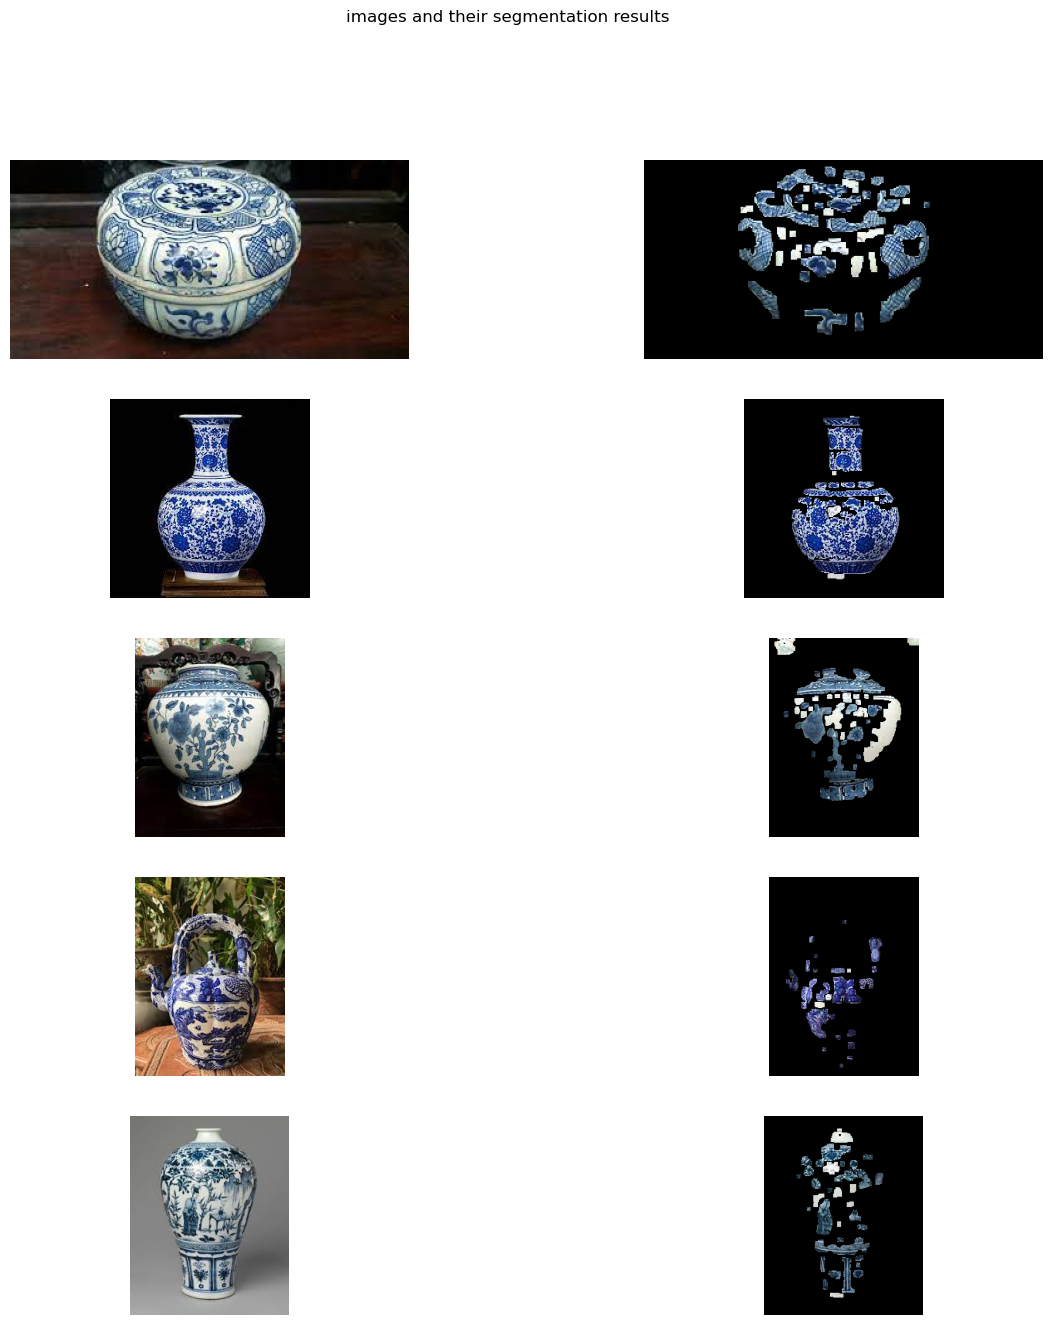

In [40]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))

for i in range(5):
    ax[i][0].imshow(imgs[i])
    ax[i][0].axis("off")
    ax[i][1].imshow(res[i])
    ax[i][1].axis("off")

fig.suptitle("images and their segmentation results")
plt.show()